In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device('cpu')

In [2]:
# read in all the words
words = open('input.txt', 'r').read().splitlines()
words[:8]

['प्रगतिशील कर्मिक और कृषक संघ सूरीनाम का एक राजनैतिक दल है। पिछ्ले विधायी चुनावों २५ मई २००५ में इसे १० मत मिले थे और राष्ट्रीय विधानसभा की किसी भी सीट पर विजय प्राप्त नहीं हुई। बाहरी कड़ियाँ सूरीनाम के राजनैतिक दल। श्रेणीसूरीनाम के राजनैतिक दल',
 'बैजनाथपुर बिहार स्थित एक गाँव है। श्रेणीभागलपुर जिला के गाँव',
 'क़त्तारा द्रोणी मुनख़फ़थ़ अलक़त्ताराह उत्तरपश्चिमी मिस्र के में लीबयाई रेगिस्तान में स्थित एक रागिस्तानी द्रोणी बेसिन है। इस द्रोणी में अफ़्रीका का दूसरा सब से निचला ज़मीनी क्षेत्र आता है जो समुद्री सतह से मीटर फ़ुट नीचे है। इस द्रोणी का क्षेत्रफल लगभग वर्ग किमी वग मील है यानि भारत के मिज़ोरम राज्य से थोड़ा छोटा। क़त्तारा द्रोणी के बीच के सबसे नीचले भाग में एक नमक का मैदान है। इसके किमी पश्चिम पर क़त्तारा से छोटी एक और द्रोणी में ओएसिस है। इस द्रोणी में केवल एक स्थाई आबादी वाला क़स्बा है जिसका नाम क़रा नख़लिस्तान है और जिसमें बर्बर जाति के लगभग लोग रहते हैं। इन्हें भी देखें मिस्र सन्दर्भ श्रेणीद्रोणियाँ श्रेणीमत्रूह मुहाफ़ज़ाह श्रेणीमिस्र श्रेणीहिन्दी विकि डीवीडी परियोजना',
 '

In [3]:
len(words)

648

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: 'ँ', 3: 'ं', 4: 'ः', 5: 'अ', 6: 'आ', 7: 'इ', 8: 'ई', 9: 'उ', 10: 'ऊ', 11: 'ऋ', 12: 'ऍ', 13: 'ऎ', 14: 'ए', 15: 'ऐ', 16: 'ऑ', 17: 'ओ', 18: 'औ', 19: 'क', 20: 'ख', 21: 'ग', 22: 'घ', 23: 'ङ', 24: 'च', 25: 'छ', 26: 'ज', 27: 'झ', 28: 'ञ', 29: 'ट', 30: 'ठ', 31: 'ड', 32: 'ढ', 33: 'ण', 34: 'त', 35: 'थ', 36: 'द', 37: 'ध', 38: 'न', 39: 'ऩ', 40: 'प', 41: 'फ', 42: 'ब', 43: 'भ', 44: 'म', 45: 'य', 46: 'र', 47: 'ऱ', 48: 'ल', 49: 'ळ', 50: 'ऴ', 51: 'व', 52: 'श', 53: 'ष', 54: 'स', 55: 'ह', 56: '़', 57: 'ऽ', 58: 'ा', 59: 'ि', 60: 'ी', 61: 'ु', 62: 'ू', 63: 'ृ', 64: 'ॄ', 65: 'ॅ', 66: 'ॆ', 67: 'े', 68: 'ै', 69: 'ॉ', 70: 'ॊ', 71: 'ो', 72: 'ौ', 73: '्', 74: 'ॐ', 75: '।', 76: '॥', 77: '०', 78: '१', 79: '२', 80: '३', 81: '४', 82: '५', 83: '६', 84: '७', 85: '८', 86: '९', 87: '॰', 0: '.'}
88


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([649757, 3]) torch.Size([649757])
torch.Size([62229, 3]) torch.Size([62229])
torch.Size([88635, 3]) torch.Size([88635])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

24968


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 4.4775
  10000/ 200000: 2.4929
  20000/ 200000: 2.0842
  30000/ 200000: 2.1619
  40000/ 200000: 2.2407
  50000/ 200000: 2.0864
  60000/ 200000: 2.1715
  70000/ 200000: 1.4950
  80000/ 200000: 1.9287
  90000/ 200000: 2.1427
 100000/ 200000: 1.9536
 110000/ 200000: 1.8560
 120000/ 200000: 1.6089
 130000/ 200000: 1.8277
 140000/ 200000: 1.7639
 150000/ 200000: 2.0595
 160000/ 200000: 2.3367
 170000/ 200000: 1.8020
 180000/ 200000: 1.6072
 190000/ 200000: 2.4597


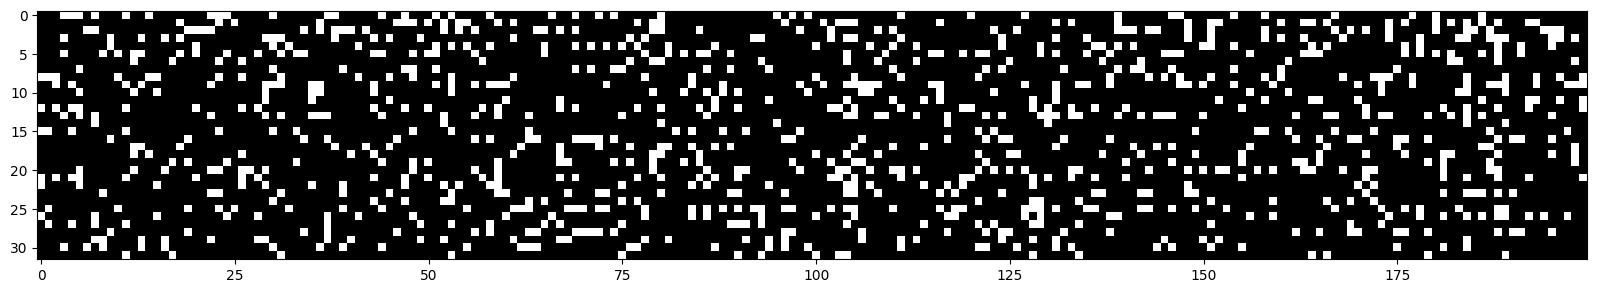

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99 ,cmap ='gray' ,interpolation='nearest')

(array([ 951.,  294.,  183.,  161.,  129.,  122.,  108.,   89.,   77.,
          77.,   79.,   75.,   80.,   69.,   54.,   71.,   54.,   80.,
          68.,   50.,   58.,   54.,   52.,   53.,   45.,   56.,   58.,
          53.,   46.,   48.,   67.,   57.,   56.,   61.,   51.,   60.,
          51.,   60.,   69.,   80.,   69.,  111.,  113.,  114.,  138.,
         152.,  144.,  236.,  294., 1023.]),
 array([-9.99999881e-01, -9.59999883e-01, -9.19999886e-01, -8.79999888e-01,
        -8.39999890e-01, -7.99999893e-01, -7.59999895e-01, -7.19999897e-01,
        -6.79999900e-01, -6.39999902e-01, -5.99999905e-01, -5.59999907e-01,
        -5.19999909e-01, -4.79999912e-01, -4.39999914e-01, -3.99999917e-01,
        -3.59999919e-01, -3.19999921e-01, -2.79999924e-01, -2.39999926e-01,
        -1.99999928e-01, -1.59999931e-01, -1.19999933e-01, -7.99999356e-02,
        -3.99999380e-02,  5.96046448e-08,  4.00000572e-02,  8.00000548e-02,
         1.20000052e-01,  1.60000050e-01,  2.00000048e-01,  2.400000

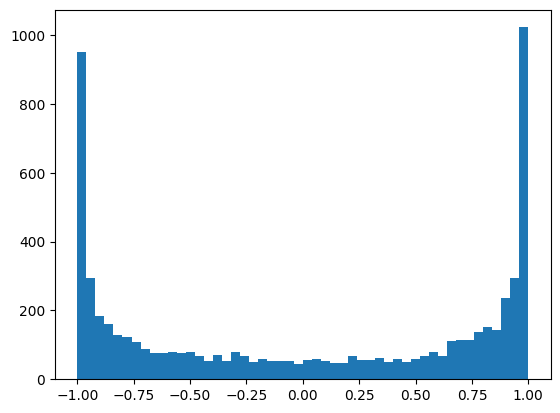

In [9]:
plt.hist(h.view(-1).tolist(),50)

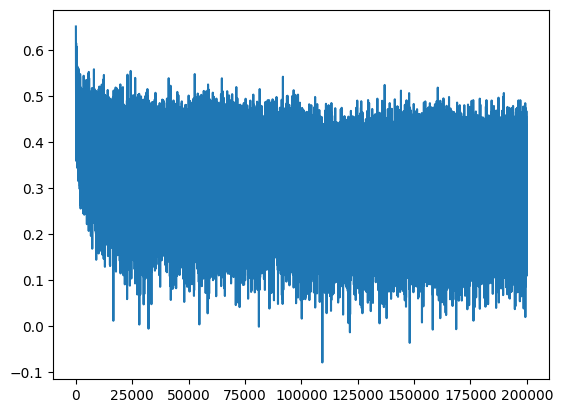

In [10]:
plt.plot(lossi)

In [11]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [12]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')

split_loss('val')

train 1.9068998098373413
val 1.9892666339874268


In [13]:
# loss log
# original:
# train 2.1245384216308594 val 2.168196439743042

# fix softmax confidently wrong:
# train 2.07 val 2.13

# fix tanh layer too saturated at init:
# train 2.0355966091156006 val 2.1026785373687744

# use semi-principled "kaiming init" instead of hacky init:
# train 2.0376641750335693 val 2.106989622116089

# add batch norm layer
# train 2.0668270587921143 val 2.104844808578491

In [14]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  

class Tanh:

  def __call__(self, x):
      self.out = torch.tanh(x)
      return self.out
  def parameters(self):
      return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

53856


In [15]:
# same optimization as last time

# device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_device(device)
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 4.4907
  10000/ 200000: 2.2591
  20000/ 200000: 2.3295
  30000/ 200000: 2.2963
  40000/ 200000: 1.9902
  50000/ 200000: 2.2275
  60000/ 200000: 1.6861
  70000/ 200000: 1.7896
  80000/ 200000: 2.0291
  90000/ 200000: 2.5111
 100000/ 200000: 2.0687
 110000/ 200000: 1.5752
 120000/ 200000: 2.0155
 130000/ 200000: 1.5346
 140000/ 200000: 1.5703
 150000/ 200000: 2.4110
 160000/ 200000: 2.1922
 170000/ 200000: 1.8820
 180000/ 200000: 2.1380
 190000/ 200000: 1.6683


layer 2 (      Tanh): mean +0.00, std 0.76, saturated: 20.81%
layer 5 (      Tanh): mean +0.02, std 0.78, saturated: 23.56%
layer 8 (      Tanh): mean +0.02, std 0.77, saturated: 23.62%
layer 11 (      Tanh): mean +0.01, std 0.78, saturated: 23.44%
layer 14 (      Tanh): mean +0.00, std 0.80, saturated: 25.34%


Text(0.5, 1.0, 'activation distribution')

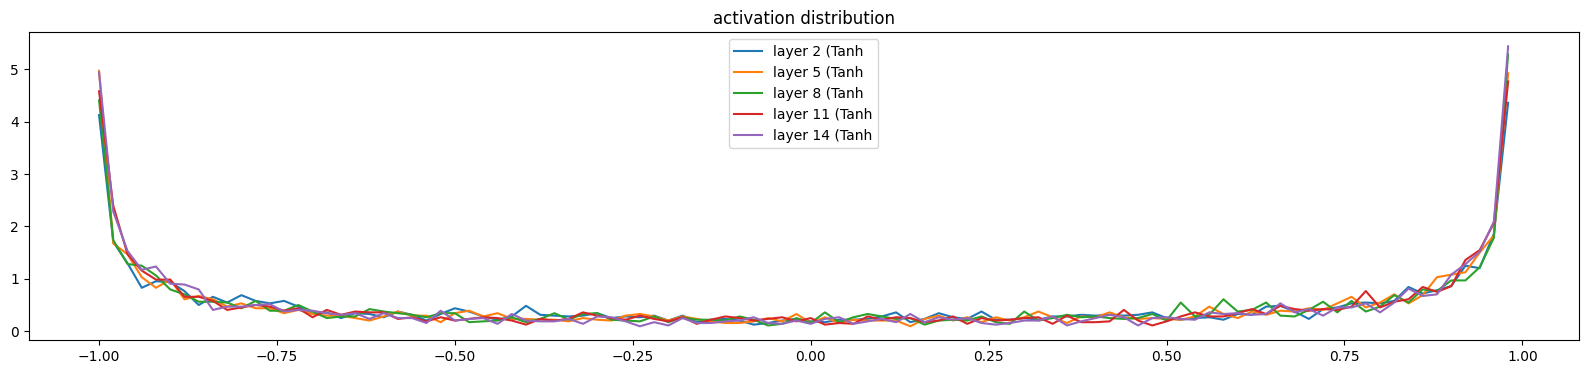

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 5.487436e-03
layer 5 (      Tanh): mean -0.000000, std 5.194007e-03
layer 8 (      Tanh): mean -0.000000, std 4.832743e-03
layer 11 (      Tanh): mean +0.000000, std 4.466005e-03
layer 14 (      Tanh): mean -0.000000, std 4.466063e-03


Text(0.5, 1.0, 'gradient distribution')

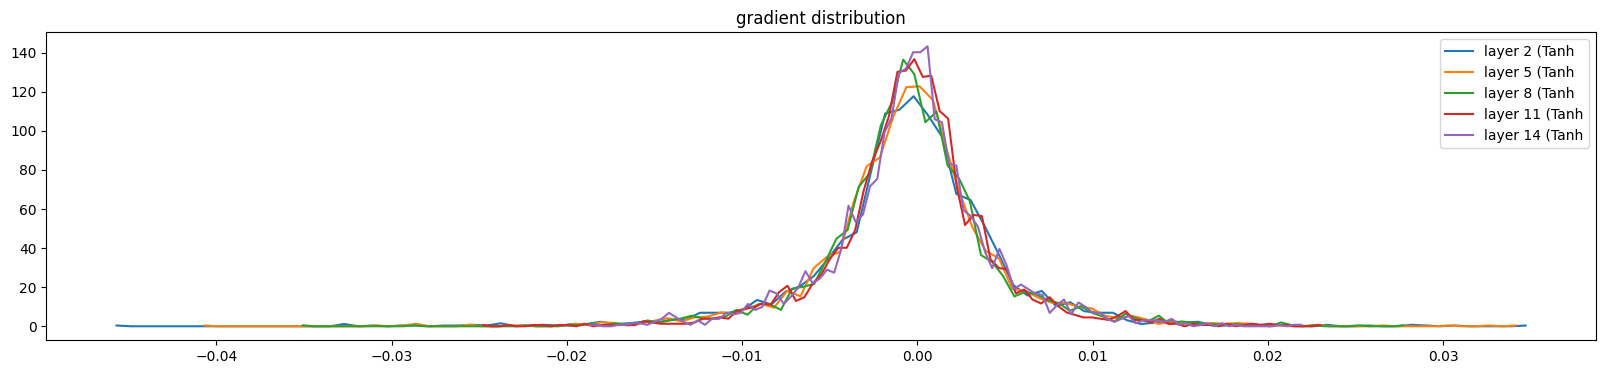

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (88, 10) | mean +0.000000 | std 1.223423e-02 | grad:data ratio 1.135427e-02
weight  (30, 100) | mean +0.000160 | std 1.039242e-02 | grad:data ratio 1.950937e-02
weight (100, 100) | mean +0.000034 | std 6.559832e-03 | grad:data ratio 1.964203e-02
weight (100, 100) | mean -0.000022 | std 6.054655e-03 | grad:data ratio 1.823811e-02
weight (100, 100) | mean -0.000084 | std 5.917943e-03 | grad:data ratio 1.826129e-02
weight (100, 100) | mean -0.000073 | std 5.519092e-03 | grad:data ratio 1.771108e-02
weight  (100, 88) | mean -0.000009 | std 5.919750e-03 | grad:data ratio 1.858236e-02


Text(0.5, 1.0, 'weights gradient distribution')

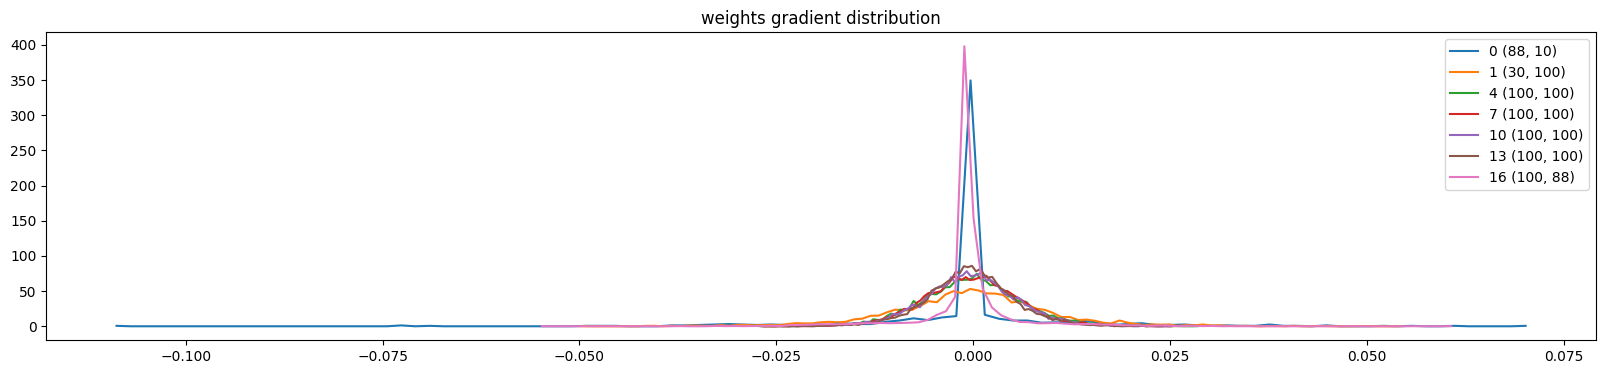

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

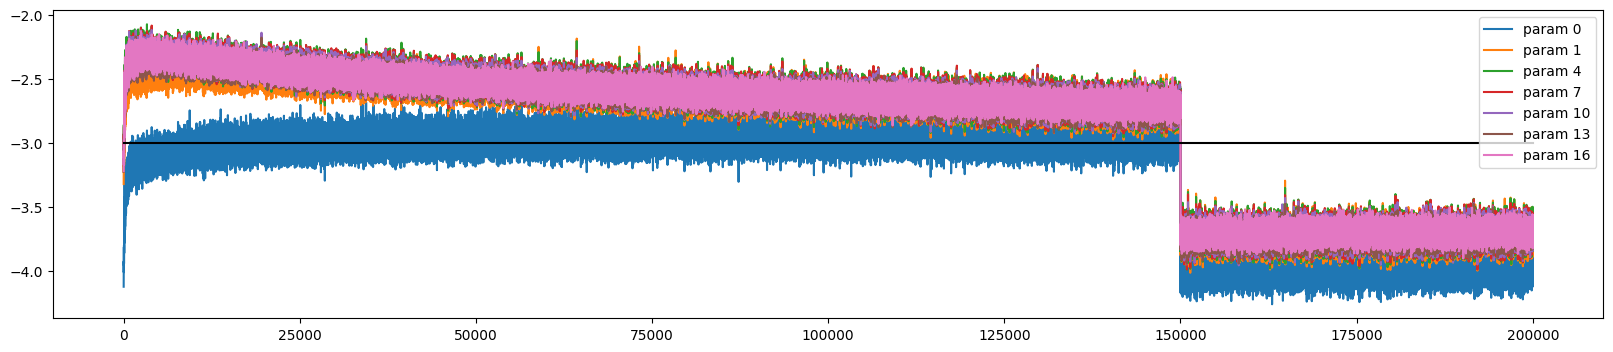

: 

In [19]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [20]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

In [100]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
madhayla.
reisra.
ejdra.
grazered.
elin.
shivaelle.
elisson.
arleigh.
malaia.
noshubergiagriel.
kin.
renleigh.
terianuel.
ged.
ryylani.
elsy.
majahsanyah.
halisa.
